# TP Braess Paradox and Price of Anarchy

## 1 Recall on the user-equilibrium and the social-optimum

Consider a (finite) directed graph $G=(V,E)$. We consider 
$K$ origin-destination vertex pair $\{o^k,d^k\}_{k\in [1,K]}$. 

Let denotes by
+ $r^k$ the intensity of the flow of user entering in $o^k$ and exiting in 
$d^k$;
+ $\mathcal{P}_k$ the set of all simple (i.e. 
without cycle) path form $o^k$ to $d^k$, and by $\mathcal{P}=\bigcup_{k=1}^K 
\mathcal{P}_k$;
+ $f_p$ the flux of user taking path $p \in \mathcal{P}$;
+ $f = \{f_p\}_{p\in\mathcal{P}}$ the vector of path-flux;
+ $x_e$ the flux of user taking the edge $e \in E$;
+ $x=\{x_e\}_{e\in E}$ the vector of edge-flux;
+ $\ell_e : \mathbb{R} \to \mathbb{R}^+$ the cost incurred by a given user 
to take arc 
$a$;
+ $L_e(x_e) := \int_0^{x_e}\ell_e(u)du$.


Minimizing the total cost of the system is an optimization problem that reads


\begin{align}
(P^{SO}) \quad \min_{x,f} \quad & \sum_{e\in E} x_e \ell_e(x_e) \\
 s.t. \quad & r_k = \sum_{p\in\mathcal{P}_k}f_p & k = 1..K 
\label{cst:flux-spread}\\
 & x_e = \sum_{p \ni e} f_p & e \in E \label{cst:xa-def}\\
 & f_p \geq 0 & p \in \mathcal{P}
\end{align}

Where the first constraint ensure that the flux going from $o^k$ 
to $d^k$ is spread among the different possible paths 
and the second constraint is the definition of $x_a$ as the sum of the 
users taking the different path containing arc $a$.

Recall that if $\ell_e$ is non-decreasing we can guarantee that $f$ is a user 
equilibrium (cf course) if and only if it is a solution of

\begin{align}
(P^{UE})  \min_{x,f} \quad & \sum_{e\in E}L_e(x_e) \\
 s.t. \quad & r_k = \sum_{p\in\mathcal{P}_k}f_p & k \in 1..K\\
 & x_e = \sum_{p \ni e} f_p & e \in E \\
 & f_p \geq 0 & p \in \mathcal{P}
\end{align}
where the only difference with $(P^{SO})$ is the 
objective function.

### Question 1 
Prove that if for all arc $\ell_e$ is constant then social optimum and 
user-equilibrium are equivalent.

## 2 Reformulating the problem

A complete graph $(V,E)$ is a graph such that for all couple of vertices
$(v_1,v_2)$ there exists an arc with origin $v_1$ and destination $v_2$.

### Question 2

Consider a complete directed graph of $n$ nodes with $1$ origin and $1$ 
destination. What is the dimension of the vector $f$ ? of $x$ ? So how many 
variables and constraints (except positivity constraints) is there for the user 
equilibrium (or the social optimum) problem ?

### Question 3

Rewrite both $(P^{(UE)})$ and $(P^{(SO)})$ using only vector $f$.

### Question 4

Assuming that there is only one origin and destination (i.e. $K=1$)
 Rewrite both problems using only vector $x$.

### Question 5

Let $N$ be a matrix with $|V|$ line and $|A|$ column, such that $N_{od}$ 
equal to $-1$ if the origin of $e$ is $o$, $+1$ if the destination of $e$ is 
$d$ and $0$ elsewhere. Thus each column of $N$ corresponds to an arc and 
indicate its origin with a $-1$ and its destination with a $+1$.

If $K=1$, what is the interpretation of each coordinate of the vector $Nx$ ? 
Deduce a more condensed presentation of both problems using only vector $x$.

## Setting up the optimization problem in Julia


We are going to install some package that are required for the practical session. If running on JuliaBox you should install through its interface directly.

In [1]:
Pkg.add("MetaGraphs") # Should be done directly on JuliaBox
Pkg.add("LightGraphs")
Pkg.add("GraphPlot")
Pkg.add("JuMP")
Pkg.add("Ipopt")

INFO: Pkg operations are not possible on JuliaBox. Please use the "Packages" menu at the top of the main screen.
INFO: Pkg operations are not possible on JuliaBox. Please use the "Packages" menu at the top of the main screen.
INFO: Pkg operations are not possible on JuliaBox. Please use the "Packages" menu at the top of the main screen.
INFO: Pkg operations are not possible on JuliaBox. Please use the "Packages" menu at the top of the main screen.
INFO: Pkg operations are not possible on JuliaBox. Please use the "Packages" menu at the top of the main screen.


We now set up the graph we want to study, which is the classical Braess example.

In [2]:
using LightGraphs, MetaGraphs #Graph Libraries
using GraphPlot

# Constructing a Directed Graph (with Meta-data) with 4 nodes
G = MetaDiGraph(4)

# setting the input / output flux
set_props!(G,1,Dict(:io=>-1,:x=>0,:y=>0)) # incoming flux of intensity 1 
set_props!(G,2,Dict(:io=>0,:x=>1,:y=>1))
set_props!(G,3,Dict(:io=>0,:x=>1,:y=>-1))
set_props!(G,4,Dict(:io=>1,:x=>2,:y=>0)) # outgoing flux of intensity 1

# adding edges with attached metadata
add_edge!(G, 1, 2) 
set_props!(G, 1, 2,Dict(:a=>1., :b => 0, :idx => 1)) # the cost of edge 1 -> 2 is a x + b = x 

add_edge!(G, 1, 3)
set_props!(G, 1, 3, Dict(:a=>0., :b => 1, :idx => 2))#idx stands for the index corresponding to the edge-flow in the x vector

add_edge!(G, 2, 4)
set_props!(G, 2, 4, Dict(:a=>0., :b => 1, :idx => 3))

add_edge!(G, 3, 4)
set_props!(G, 3, 4, Dict(:a=>1, :b => 0, :idx => 4))

LoadError: [91mArgumentError: Module MetaGraphs not found in current path.
Run `Pkg.add("MetaGraphs")` to install the MetaGraphs package.[39m

In [3]:
#Pkg.add(PyPlot) #Directly through JuliaBox
using PyPlot 

In [4]:
#This function represent a Graph
function plot_graph(G,plot_edges = false, plot_vertices = false)
    posx = zeros(nv(G))
    posy = zeros(nv(G))
    for v in 1:nv(G)
        posx[v] = get_prop(G,v,:x)
        posy[v] = get_prop(G,v,:y)
        if plot_vertices
            text(posx[v],posy[v],v)
        end
    end
    scatter(posx, posy, s=50) # plotting edges
    
    for e in edges(G) #edge s -> t
        x_s,y_s = posx[src(e)], posy[src(e)]
        x_t,y_t = posx[dst(e)], posy[dst(e)]
        arrow(x_s, y_s, x_t - x_s, y_t - y_s,
            head_width=0.05, length_includes_head=true)
        if plot_edges
            δ_x, δ_y = 0.05.*(y_s-y_t , x_t - x_s)
            text(0.5*x_s+0.5*x_t + δ_x, 0.5*y_s+0.5*y_t + δ_y, get_prop(G,e,:idx)) # edges number
        end
    end
end
plot_graph(G,true,true)

LoadError: [91mUndefVarError: G not defined[39m

In [5]:
# Matrix representation of conservation law :: Nx = io
io = [get_prop(G,i,:io) for i=1:nv(G)]

N = zeros(Int,(nv(G),ne(G)))
for e in edges(G)
    j = get_prop(G,e,:idx)
    N[src(e),j] = -1 
    N[dst(e),j] = 1
end

LoadError: [91mUndefVarError: G not defined[39m

## Computing the price of anarchy

Define $C(x)=\sum_{a\in A}x_a \ell_a(x_a)$ the price associated with the 
admissible flux $x$. We denote by $x^{UE}$ the user equilibrium, and $x^{SO}$
the social optimum. The price of anarchy is by definition 
$$PoA = \frac{C(x^{UE})}{C(x^{SO})} \geq 1 .$$

In [6]:
using JuMP, Ipopt #Modeler and Optimizer

In [7]:
### Computing Social Optimum for graph G
function SO(G,display = false)
    # Setting up the optimization model
    m_so = Model(solver=IpoptSolver(print_level=0))
    @variable(m_so,x_so[1:ne(G)] >= 0)    # (non-negative) arc-intensity
    @variable(m_so,cost_so[1:ne(G)]) # cost by edge
    @constraint(m_so,N*x_so .== io)       # Conservation law
    

    # Defining social optimum cost 
    for e in edges(G)
        idx = get_prop(G,e,:idx)   # getting index of edge 
        a = get_prop(G,e,:a)       # get coefficient a of the cost function
        b = get_prop(G,e,:b)       # get coefficient b of the cost function
        @NLconstraint(m_so,cost_so[idx] == a*x_so[idx]^2 + b*x_so[idx]) 
    end
    @NLobjective(m_so,Min,sum(cost_so[idx] for idx=1:ne(G)))

    # Solving the optimisation problem
    solve(m_so)
     
    if display
        # Printing the computed intensity on all edges
        for e in edges(G)
            print(e)
            print(" has intensity ")
            println(round(getvalue(x_so[get_prop(G,e,:idx)]),2))
        end
    end
    
    return getobjectivevalue(m_so)  # return the total cost of the social optimum
end
SO(G)

LoadError: [91mUndefVarError: G not defined[39m

### Question 6

From the function computing the social optimum, define a function computing the user equilibrium. 

Deduce the price of anarchy of this network. Comment the solution.

### Question 7

Add one edge form node $1$ to $2$ with null cost. Compute the price of anarchy.

Add one edge form node $2$ to $1$ with null cost. Compute the price of anarchy.

Add both edges. Compute the price of anarchy.

Look at obtained intensities, and comment the result.

### Question 8

In the previous graph modify the constant cost functions equal to $1$
into cost of the form $1+0.5x$. What do you observe on optimal solutions
$x^{UE}$ and $x^{S0}$ ? Comment.

### Question 9

Choose random affine latency on each arc, the coefficients being chosen uniformly on
$[0,1]$ (using rand()). Plot an histogram of the price of anarchy over
$100$ realization. What result from the course do we observe ?

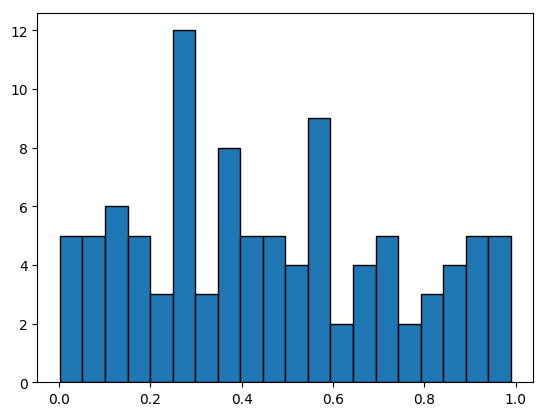

In [8]:
# Plotting an histogram
x = vec(1:100)
y = rand(100)
PyPlot.plt[:hist](y, bins=20, edgecolor="k");

### Question 10

Adapt the code such that each arc has now a cost function of the form
$\ell_e(x_e) = t_e(1+0.15*(x_e/c_e)^4)$.

 Plot an histogram of the price of anarchy over $100$ realization of $t_e$ and $c_e$. Comment.

## More complex graphs

### Question 11

Construct a graph with $6$ nodes. Define linear costs on each arc. 
Compute the price of anarchy.

### Question 12 

On your new graph test if it is possible to add an arc with null cost
that increase the cost of the user equilibrium.

### Question 13

By introducing edge-flux variables $x^1$ and $x^2$ rewrite
the user equilibrium and social optimum problems in the case
where $K=2$. 

Construct an example on your previous graph and compute the price
of anarchy.